In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

!pip install black[jupyter] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.1 MB/s eta 0:00:00


In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!black "/content/drive/My Drive/Colab Notebooks/Sentiment-analysis.ipynb"

All done! ✨ 🍰 ✨
1 file left unchanged.


In [ ]:
root = "/content/drive/My Drive/Sentiment-analysis-project"
os.listdir(root)

['val.txt', 'test.txt', 'train.txt']

In [ ]:
def preprocess_text(text):
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower()

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words("english")]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
def load_data(file_path, train=True):
    with open(os.path.join(root, file_path), "r") as file:
        sentences = []
        emotions = []

        for line in file:
            line = line.strip()
            if not line:
                continue

            sentence, emotion = line.split(";")

            sentences.append(sentence)
            emotions.append(emotion)

        df = pd.DataFrame({"text": sentences, "emotion": emotions})
        df["text"] = df["text"].apply(preprocess_text)

        if train:
            df['emotion'] = label_encoder.fit_transform(df['emotion'])
        else:
            df['emotion'] = label_encoder.transform(df['emotion'])

        return df['text'], df['emotion']

In [ ]:
X_train, y_train = load_data("train.txt", True)
X_test, y_test = load_data("test.txt", False)
X_val, y_val = load_data("val.txt", False)

In [ ]:
max_words = 5000
max_len = 100
embedding_dim = 128

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(y_train.unique()), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train_pad, y_train, epochs=50, batch_size=64, validation_data=(X_val_pad, y_val))

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 266ms/step - accuracy: 0.3628 - loss: 1.5574 - val_accuracy: 0.7505 - val_loss: 0.6821
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 261ms/step - accuracy: 0.8277 - loss: 0.5120 - val_accuracy: 0.8925 - val_loss: 0.3226
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 258ms/step - accuracy: 0.9280 - loss: 0.2289 - val_accuracy: 0.9115 - val_loss: 0.2558
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 257ms/step - accuracy: 0.9524 - loss: 0.1409 - val_accuracy: 0.9160 - val_loss: 0.2416
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 277ms/step - accuracy: 0.9658 - loss: 0.1059 - val_accuracy: 0.9220 - val_loss: 0.2484
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 257ms/step - accuracy: 0.9755 - loss: 0.0787 - val_accuracy: 0.9150 - val_loss: 0.2845
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 256ms/step - accuracy: 0.9732 - loss: 0.0713 - val_accuracy: 0.9225 - val_loss: 0.2721
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 272ms/step - accuracy: 0.9807 - loss: 0

In [ ]:
y_pred = np.argmax(model.predict(X_test_pad), axis=-1)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step
              precision    recall  f1-score   support

       anger       0.90      0.94      0.92       275
        fear       0.87      0.92      0.90       224
         joy       0.96      0.92      0.94       695
        love       0.77      0.89      0.82       159
     sadness       0.97      0.95      0.96       581
    surprise       0.81      0.67      0.73        66

    accuracy                           0.92      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.93      0.92      0.92      2000



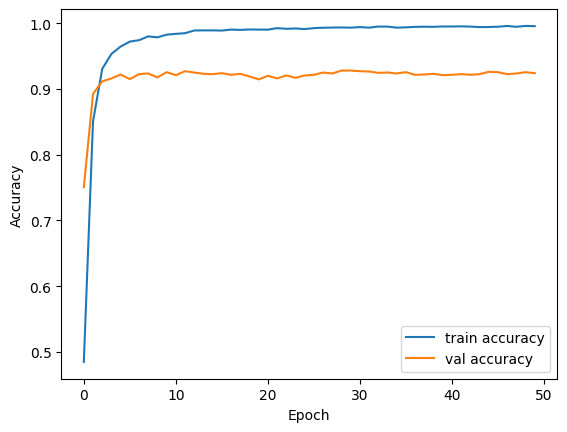

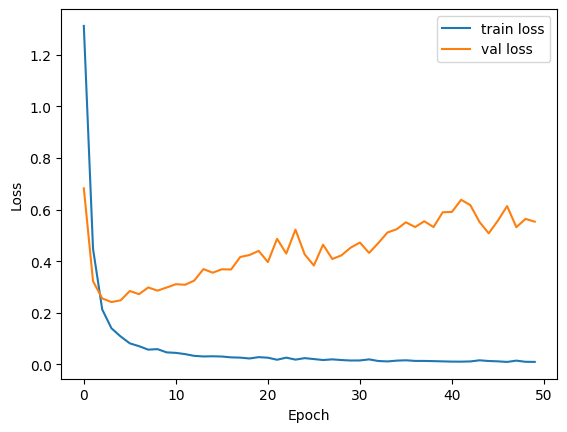

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

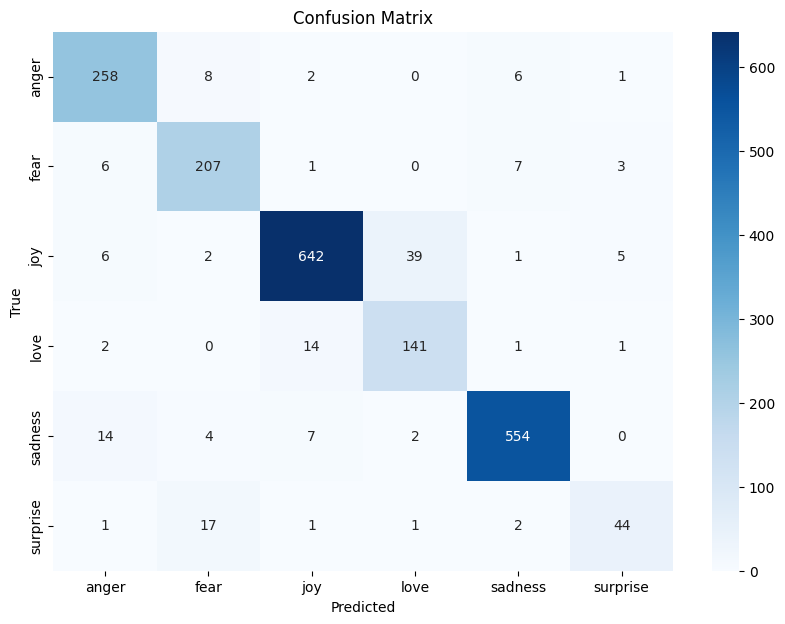

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def get_answer(text):
    cleaned_text = preprocess_text(text)

    # Tokenize and pad the sequence
    input_seq = tokenizer.texts_to_sequences([cleaned_text])
    input_pad = pad_sequences(input_seq, maxlen=max_len)

    prediction = model.predict(input_pad)
    predicted_label_idx = np.argmax(prediction, axis=-1)[0]
    predicted_emotion = label_encoder.inverse_transform([predicted_label_idx])[0]

    return predicted_emotion

In [ ]:
get_answer("You are a naughty school girl")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


'love'